In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
import numpy as np
import pandas as pd
from datetime import date,datetime,timedelta
from pytz import timezone

import matplotlib.pyplot as plt

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [2]:
# read in data 
df=pd.read_csv('SendTech_Anomaly_Data.csv')
df.head()

,METER_SERIES,TRANS_DAY,HOUR,TOTAL_AMOUNT,TOTAL_PIECE_COUNT,SHIPPING_SPEND,MAILING_SPEND,MAILING_COUNT,SHIPPING_COUNT
0,P-Series,2020-05-06 10:00:00.000,10,316504.973646,472935,3.21,316502.62,472934,1
1,P-Series,2020-05-06 21:00:00.000,21,116808.741619,191741,832.45,115976.40,191577,164
2,Connect+,2020-05-06 17:00:00.000,17,119546.910867,181599,0.00,119547.14,181599,0
3,Connect+,2020-05-06 06:00:00.000,6,2909.491993,6018,0.00,2909.61,6018,0
4,P-Series,2020-05-07 10:00:00.000,10,281996.455688,410649,15.28,281981.87,410647,2


In [3]:
df=df[['METER_SERIES', 'TRANS_DAY','TOTAL_PIECE_COUNT']]
df.head()

,METER_SERIES,TRANS_DAY,TOTAL_PIECE_COUNT
0,P-Series,2020-05-06 10:00:00.000,472935
1,P-Series,2020-05-06 21:00:00.000,191741
2,Connect+,2020-05-06 17:00:00.000,181599
3,Connect+,2020-05-06 06:00:00.000,6018
4,P-Series,2020-05-07 10:00:00.000,410649


In [4]:
#rename column
old_name=[df.columns[ind] for ind in range(3)]
new_name=['METER_SERIES',
          'EVENT_DATE',
          'TOTAL_COUNT'         
         ]
for old_col, new_col in zip(old_name,new_name):
    df.rename(columns={old_col:new_col},inplace=True)

df.head()

,METER_SERIES,EVENT_DATE,TOTAL_COUNT
0,P-Series,2020-05-06 10:00:00.000,472935
1,P-Series,2020-05-06 21:00:00.000,191741
2,Connect+,2020-05-06 17:00:00.000,181599
3,Connect+,2020-05-06 06:00:00.000,6018
4,P-Series,2020-05-07 10:00:00.000,410649


In [5]:
#group-by parameter
tracking_variable, date_variable, actual_value = new_name
tracking_object='Meter'

In [6]:
# find min and max datetime in data and change to datetime format
print(min(df[date_variable]),'-',max(df[date_variable]))
df[date_variable]=pd.to_datetime(df[date_variable])

df.head()

2020-01-01 00:00:00.000 - 2021-08-02 23:00:00.000


,METER_SERIES,EVENT_DATE,TOTAL_COUNT
0,P-Series,2020-05-06 10:00:00,472935
1,P-Series,2020-05-06 21:00:00,191741
2,Connect+,2020-05-06 17:00:00,181599
3,Connect+,2020-05-06 06:00:00,6018
4,P-Series,2020-05-07 10:00:00,410649


In [7]:
total_day=(max(df[date_variable]) - min(df[date_variable])).days
print(total_day)

579


In [8]:
# import prophet
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [9]:
# empty dataframe to append forecast results
Final=pd.DataFrame()

In [10]:
# find unique trackingID
tracking_list=list(df[tracking_variable].unique())
print(tracking_list)

['P-Series', 'Connect+', 'Unknown', 'C-Series']


In [11]:
# length of training period (days) - 70% of total days
training_period=round(0.7*total_day,0) 

# training interval increment (days)
interval=7

# window between checkpoint (hours)
window='6H'

#number of forecast (based on windows between checkpoint)
number_of_forecast = 24/int(window[0])

for trk in tracking_list:
    print(tracking_object,trk)

    # sort tracking event by key
    pre_train=df[df[tracking_variable]==trk]

    #drop trackingID column
    pre_train.drop([tracking_variable],axis=1,inplace=True) 

    # the n+1 day - the day after as a start date for forecasting
    min_val=(min(pre_train[date_variable])+timedelta(days=1)).round('D')
    max_val=max(pre_train[date_variable])

    temp=pd.DataFrame()

    # sort datetime by Event_Key
    # 6-hour increment
    temp[date_variable]=pd.Series(pd.date_range(min_val,max_val,freq=window))

    pre_train=pre_train.merge(temp,how='right',left_on=date_variable,right_on=date_variable)
    pre_train[date_variable]=pre_train[date_variable].fillna(0)

    # training period
    len_train=pd.to_datetime(min_val)+timedelta(days=training_period) 
    flag=len_train

#     pre_train.dropna(inplace=True)
    pre_train=pre_train.sort_values([date_variable])

    while (flag+timedelta(days=interval))<=pd.to_datetime(max_val):
        forecast=pd.DataFrame()

        # training set with datetime smaller than flag
        # rename column and convert to datetime format
        train=pre_train[pre_train[date_variable]<flag]
        train.columns = ['ds', 'y']
        train['ds']= pd.to_datetime(train['ds'])

        # define the model
        model = Prophet(interval_width=0.95)
#         daily_seasonality=True
#         yearly_seasonality=False

        # fit the model
        model.fit(train)

        # future dataframe with the beginning of training period as a start date
        # 6-hourly period in 7 days
        future=pd.DataFrame(pd.Series(pd.date_range(start=flag, periods=number_of_forecast*interval,\
                                                    freq=window)),columns=['ds'])

        forecast = model.predict(future)
        forecast[tracking_object]=trk

        #append forecast result
        Final=Final.append(forecast)
        flag=flag+timedelta(days=interval)

Meter P-Series


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly 

Meter Connect+


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Meter Unknown


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Meter C-Series


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

In [25]:
#group-by for output file
col_list=['ds',
          'yhat',
          'yhat_lower',
          'yhat_upper'
         ]
forecast_datetime, predicted_value, lower_value, upper_value = col_list

In [26]:
# final y-hat=0 if smaller than 0
Final[predicted_value]=np.where(Final[predicted_value]<0,0,Final[predicted_value])

df_t=df
df_t[date_variable]=pd.to_datetime(df_t[date_variable])

Final_CSV=Final.merge(df_t,how='left',left_on=[forecast_datetime,tracking_object],\
                      right_on=[date_variable,tracking_variable])
Final_CSV[actual_value]=Final_CSV[actual_value].fillna(0)
Final_CSV.to_csv('IND3_Anomaly_Output_7Day.csv')

In [27]:
final_tracking_list=list(Final_CSV[tracking_object].unique())
print(final_tracking_list)

total_final_day=(max(Final_CSV[forecast_datetime]) - min(Final_CSV[forecast_datetime])).days
print(total_final_day)

['P-Series', 'Connect+', 'Unknown', 'C-Series']
167


In [28]:
# cleaning before visualization

# no negative volume: 0 for yhat_lower < 0
Final_CSV[lower_value]=np.where(Final_CSV[lower_value]<0,0,Final_CSV[lower_value])
Final_CSV[upper_value]=np.where(Final_CSV[upper_value]<0,0,Final_CSV[upper_value])

# round to nearest int
values_need_rounding=[upper_value,lower_value,predicted_value]

for val in values_need_rounding:
    Final_CSV[val]=Final_CSV[val].round(decimals=0)

# Final_CSV.head()
Final_CSV.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Meter,METER_SERIES,EVENT_DATE,TOTAL_COUNT
2683,2021-07-26 18:00:00,98120.440289,155856.0,428539.0,98072.528705,98168.433566,190694.814510,190694.814510,190694.814510,167160.700309,...,23534.114201,23534.114201,0.0,0.0,0.0,288815.0,C-Series,C-Series,2021-07-26 18:00:00,420833.0
2684,2021-07-27 00:00:00,98147.276383,0.0,224577.0,98094.497900,98199.921500,-15868.189575,-15868.189575,-15868.189575,-48338.382074,...,32470.192499,32470.192499,0.0,0.0,0.0,82279.0,C-Series,C-Series,2021-07-27 00:00:00,36586.0
2685,2021-07-27 06:00:00,98174.112476,0.0,214985.0,98116.467096,98229.261191,-29843.771574,-29843.771574,-29843.771574,-65614.130158,...,35770.358584,35770.358584,0.0,0.0,0.0,68330.0,C-Series,C-Series,2021-07-27 06:00:00,1501.0
2686,2021-07-27 12:00:00,98200.948570,37166.0,305699.0,98138.182214,98260.287636,75382.858740,75382.858740,75382.858740,39333.341427,...,36049.517314,36049.517314,0.0,0.0,0.0,173584.0,C-Series,C-Series,2021-07-27 12:00:00,191543.0
2687,2021-07-27 18:00:00,98227.784663,161106.0,438508.0,98160.603625,98289.807528,202714.579308,202714.579308,202714.579308,167160.700310,...,35553.878999,35553.878999,0.0,0.0,0.0,300942.0,C-Series,C-Series,2021-07-27 18:00:00,401347.0


In [29]:
# plot elements
graph_type='line'
y_axis=[lower_value,
        upper_value,
        predicted_value,
        actual_value]
label_list=['Lower-bound',
            'Upper-bound',
            'Predicted Values',
            'Actual Values']
color_list=['blue',
            'red',
            'gold',
            'green']

Meter P-Series


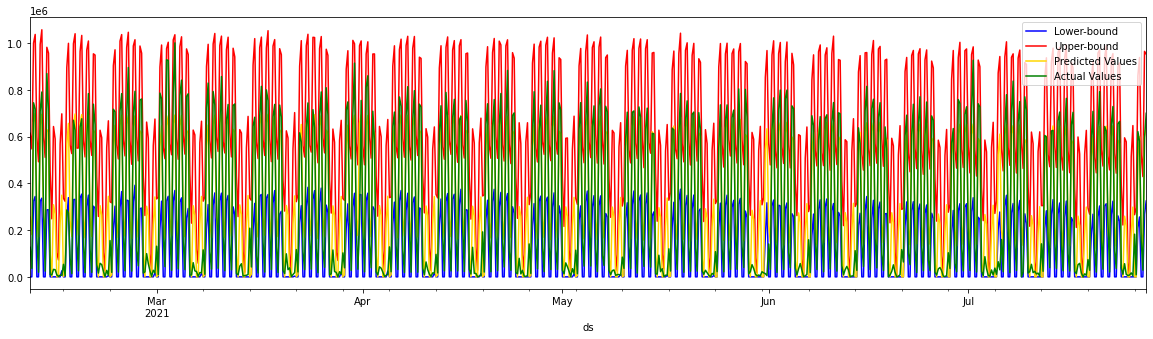

Meter Connect+


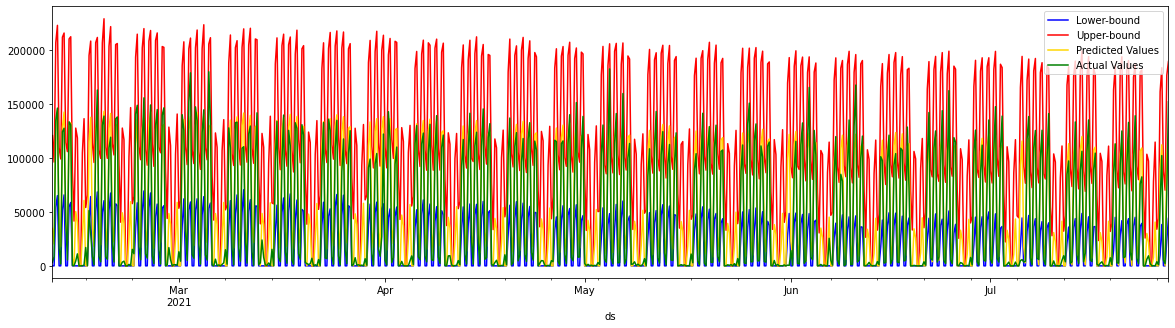

Meter Unknown


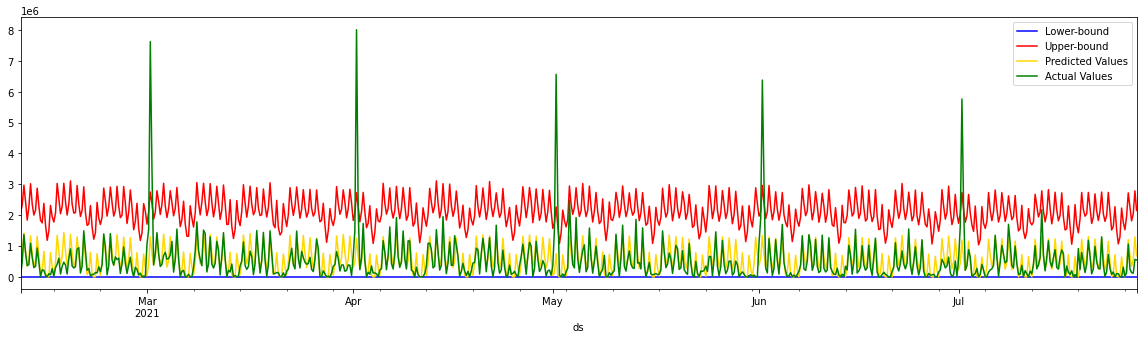

Meter C-Series


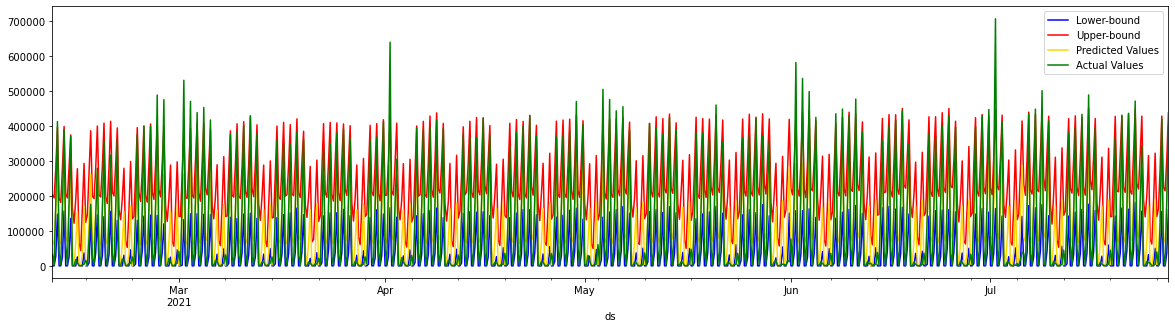

In [30]:
#all time - graph plot with date, confidence interval, predicted and actual values

for final_trk in final_tracking_list:
    print(tracking_object,final_trk) 

    spec_trk=Final_CSV[Final_CSV[tracking_object] == final_trk]

    ax = plt.gca()

    for y_val, labl, colr in zip(y_axis,label_list,color_list):
        spec_trk.plot(kind=graph_type,x=forecast_datetime,y=y_val, color=colr, label=labl, \
                        ax=ax, figsize=(20, 5))

    plt.fill_between(spec_trk.index, spec_trk.yhat_upper, spec_trk.yhat_lower, facecolor='orange',alpha=0.5)
    plt.show()


Meter P-Series


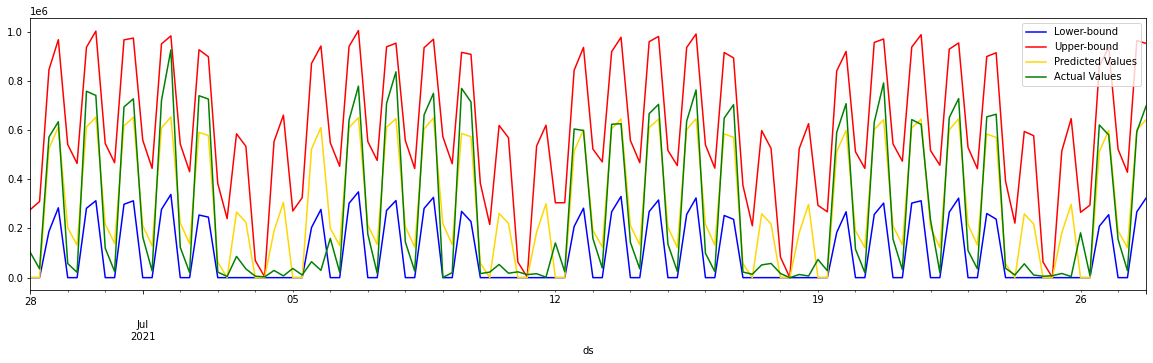

Meter Connect+


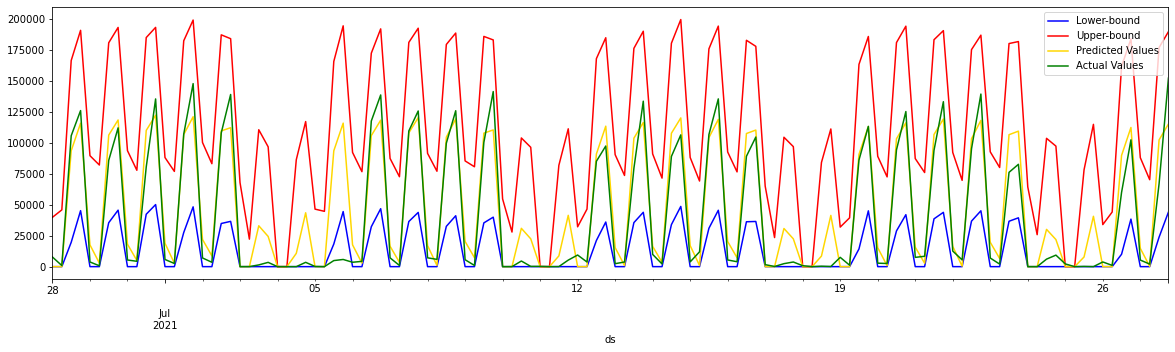

Meter Unknown


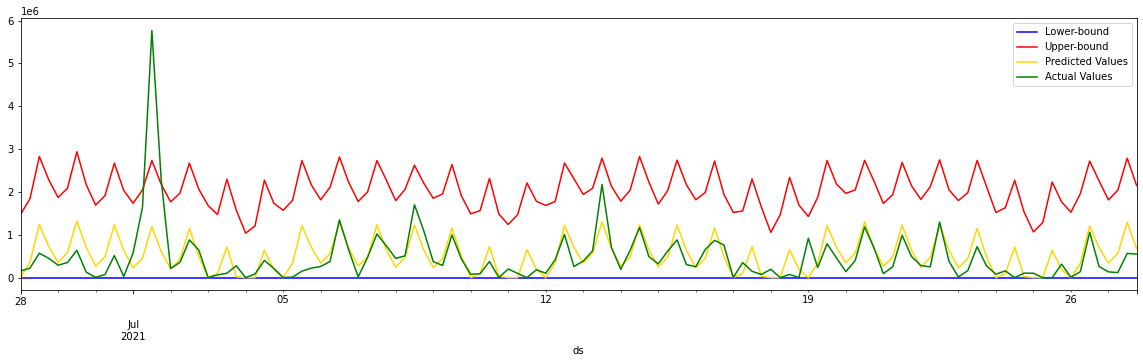

Meter C-Series


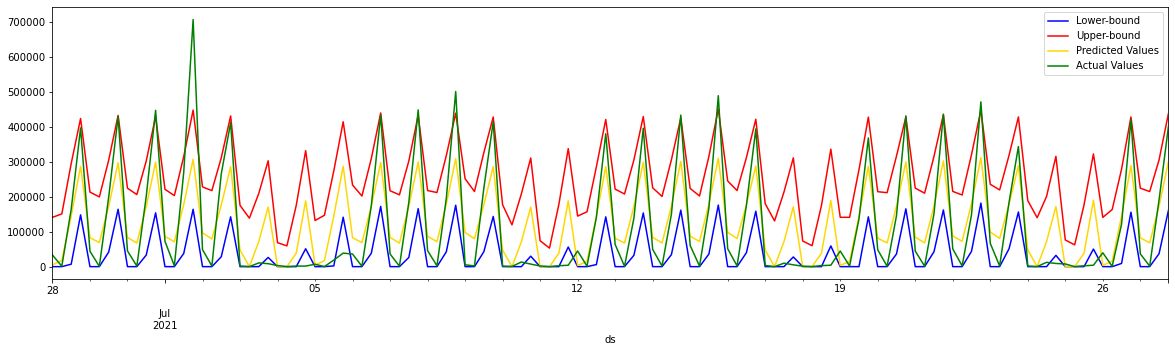

In [31]:
#most recent n days - graph plot with date, confidence interval, predicted and actual values

days_number=timedelta(days=30)

for final_trk in final_tracking_list:
    print(tracking_object,final_trk) 

    spec_trk=Final_CSV[Final_CSV[tracking_object] == final_trk]
    
    recent_30d = spec_trk[(spec_trk[forecast_datetime] > spec_trk[forecast_datetime].iloc[-1]-days_number)
                         & (spec_trk[forecast_datetime] <= spec_trk[forecast_datetime].iloc[-1])]
    ax = plt.gca()
    
    for y_val, labl, colr in zip(y_axis,label_list,color_list):
        recent_30d.plot(kind=graph_type,x=forecast_datetime,y=y_val, color=colr, label=labl, \
                        ax=ax, figsize=(20, 5))

    plt.fill_between(recent_30d.index, recent_30d.yhat_upper, recent_30d.yhat_lower, facecolor='orange',alpha=0.5)
    plt.show()

In [32]:
# all time metrics
y_pred=Final_CSV[predicted_value]
y_actual=Final_CSV[actual_value]
sample=len(Final_CSV.index)

mse = mean_squared_error(y_actual,y_pred)
rmse = math.sqrt(mse/sample)
rse = math.sqrt(mse/(sample-2))
r2=r2_score(y_actual,y_pred)
mae=mean_absolute_error(y_actual,y_pred)
median_ae=median_absolute_error(y_actual, y_pred)
mask=y_actual!=0
mape=(np.fabs((y_actual-y_pred)/y_actual))[mask].mean()
mpe=((y_actual-y_pred)/y_actual)[mask].mean()
med_ape=(np.fabs((y_actual-y_pred)/y_actual))[mask].median()
forecast_error = [y_actual[i]-y_pred[i] for i in range(len(y_pred))]
mean_forecast_error=sum(forecast_error)/len(y_pred)
smape=1/len(y_actual) * np.sum(2 * np.abs(y_pred-y_actual) / (np.abs(y_actual) + np.abs(y_pred))*100)
wape=np.sum(np.abs(y_actual-y_pred))/np.sum(np.abs(y_actual))
msle=mean_squared_log_error(y_actual, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('RSE: ', rse)
print('R^2: ', r2)
print('MAE: ', mae)
print('Median_AE: ', median_ae)
print('MPE: ', mpe)
print('MAPE:', mape)
print('MdAPE:', med_ape)
print('Mean Forecast Error: ', mean_forecast_error)
print('SMAPE: ', smape)
print('WAPE: ', wape)
print('MSLE: ', msle)
print('RMSLE: ', np.sqrt(msle))

MSE:  105323513694.85007
RMSE:  6259.620978716783
RSE:  6261.951007079151
R^2:  0.4739928682897011
MAE:  120713.98251488095
Median_AE:  52705.0
MPE:  -17.091103403166738
MAPE: 17.468892149552328
MdAPE: 0.9939907062744812
Mean Forecast Error:  -28404.178199404763
SMAPE:  94.26463120668743
WAPE:  0.5078683280749676
MSLE:  11.402250443942602
RMSLE:  3.376721848767322


In [33]:
print(round(100-wape,2))

99.49


In [20]:
#Interpretation
print("We are having an overestimated model, with a negative Mean Forecast Error.") #MFE
print("We should expect an average error of +- 101 packages, with RMSE are around 100.") #RMSE
print("The forecast error is 1.4%, meaning accuracy is 98.6%") #WAPE

### Unusable metrics interpretation ###
# print("The forecast's distance from the true value is 112% above of the true value, \ 
# which is around 3737 packages.") #MAPE/MAE
# print("Actual results are 112% less than what was forecasted. ") #MPE
# print("Half of the packages count are falling between median +- 2923 counts.") #Median_AE
# print("Half of the absolute percentage errors are less than 0.63% and half are over 0.63%.") #MdAPE

We are having an overestimated model, with a negative Mean Forecast Error.
We should expect an average error of +- 101 packages, with RMSE are around 100.
The forecast error is 1.4%, meaning accuracy is 98.6%


In [21]:
Formatted_CSV=Final_CSV

# Format output file
facility_name = 'SendTech'
forecast_purpose = 'Meter Count'

#Version - increment after each update
Formatted_CSV["Version"] = 1.0

#Forecast Date/Time
Formatted_CSV[forecast_datetime]=pd.to_datetime(Formatted_CSV[forecast_datetime])
Formatted_CSV['Forecast Date']=[(d.date()).strftime("%d %b %Y") for d in Formatted_CSV[forecast_datetime]]
Formatted_CSV['Forecast Time']=[(d.time()).strftime("%I:%M %p") for d in Formatted_CSV[forecast_datetime]]

#Lower/Upper boundary, Actuals, Forecast renames
old_name=['yhat_lower',
          'yhat_upper',
          actual_value,
          'yhat',
         ]
new_name=['Lower Boundary',
          'Upper Boundary',
          'Actual',
          'Forecast'
         ]
for old_col, new_col in zip(old_name,new_name):
    Formatted_CSV.rename(columns={old_col:new_col},inplace=True)

#Model Performance/Sensitivity
Formatted_CSV['Model Performance']=round(100-wape,2).astype(str)+"%"

#Anomaly - Predited and Actual
conditions = [
    Formatted_CSV['Actual'] < Formatted_CSV['Forecast'],
    Formatted_CSV['Actual'] > Formatted_CSV['Forecast'],
]
choices = ["Lower than expected", 
           "Higher than expected", 
          ]
Formatted_CSV['Anomaly'] = np.select(conditions,choices,default='')

#Anomaly - out of prediction interval
conditions = [
    Formatted_CSV['Actual'] < Formatted_CSV['Lower Boundary'],
    Formatted_CSV['Actual'] > Formatted_CSV['Upper Boundary']
]
choices = ["Out of Lower Bound", 
           "Out of Upper Bound", 
           ]
Formatted_CSV['Anomaly_Interval'] = np.select(conditions, choices,default='')

#Run date/time
Formatted_CSV['Run Date']=(datetime.now().date()).strftime("%d %b %Y")
Formatted_CSV['Run Time']=(datetime.now().time()).strftime("%I:%M %p")

#Sensitivity, comment - empty for now
Formatted_CSV["Sensitivity"],Formatted_CSV["Comment"] = "",""

#Monitor Name
Formatted_CSV["Monitor Name"] = facility_name +" "+ forecast_purpose
Formatted_CSV.head()

#Rearranging columns
cols = Formatted_CSV.columns.tolist()
cols = ['Monitor Name',
        'Version',
        tracking_object,
        'Run Date',
        'Run Time',
        'Forecast Date',
        'Forecast Time',
        'Model Performance',
        'Sensitivity',
        'Lower Boundary',
        'Upper Boundary',
        'Forecast',
        'Actual',
        'Anomaly',
        'Anomaly_Interval',
        'Comment'
       ]
Formatted_CSV=Formatted_CSV[cols]
Formatted_CSV.to_csv('IND3_Anomaly_Output_7Day_Formatted.csv')

In [22]:
Formatted_CSV.tail()

,Monitor Name,Version,Meter,Run Date,Run Time,Forecast Date,Forecast Time,Model Performance,Sensitivity,Lower Boundary,Upper Boundary,Forecast,Actual,Anomaly,Anomaly_Interval,Comment
2683,SendTech Meter Count,1.0,C-Series,09 Aug 2021,10:29 AM,26 Jul 2021,06:00 PM,99.49%,,155856.0,428539.0,288815.0,420833.0,Higher than expected,,
2684,SendTech Meter Count,1.0,C-Series,09 Aug 2021,10:29 AM,27 Jul 2021,12:00 AM,99.49%,,0.0,224577.0,82279.0,36586.0,Lower than expected,,
2685,SendTech Meter Count,1.0,C-Series,09 Aug 2021,10:29 AM,27 Jul 2021,06:00 AM,99.49%,,0.0,214985.0,68330.0,1501.0,Lower than expected,,
2686,SendTech Meter Count,1.0,C-Series,09 Aug 2021,10:29 AM,27 Jul 2021,12:00 PM,99.49%,,37166.0,305699.0,173584.0,191543.0,Higher than expected,,
2687,SendTech Meter Count,1.0,C-Series,09 Aug 2021,10:29 AM,27 Jul 2021,06:00 PM,99.49%,,161106.0,438508.0,300942.0,401347.0,Higher than expected,,


In [23]:
#count number of out of bound records and its percentage
#total_oob is summed by upper_oob and lower_oob, which is the number of records falling out of upper/lower bound

total_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] != '')])
upper_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] == 'Out of Upper Bound')])
lower_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] == 'Out of Lower Bound')])

#these percentages are based on total number of records
print("Total out-of-bound forecast: ", total_oob, "-", round((total_oob/len(Formatted_CSV))*100,2),"%")
print("Total of upper OOB forecast: ", upper_oob, "-", round((upper_oob/len(Formatted_CSV))*100,2),"%")
print("Total of lower OOB forecast: ", lower_oob, "-", round((lower_oob/len(Formatted_CSV))*100,2),"%\n")

for final_trk in final_tracking_list:    
    print(tracking_object,final_trk)
    total_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] != '')&\
                                  (Formatted_CSV[tracking_object]==final_trk)])
    upper_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] == 'Out of Upper Bound')&\
                                  (Formatted_CSV[tracking_object]==final_trk)])
    lower_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] == 'Out of Lower Bound')&\
                                  (Formatted_CSV[tracking_object]==final_trk)])
    total_tracking= len(Formatted_CSV[(Formatted_CSV[tracking_object]==final_trk)])
    
    #these percentages based on the total number of records for a specific event
    print("Total OOB: ", total_oob, "-",round((total_oob/total_tracking)*100,2),"%")
    print("Upper OOB: ", upper_oob, "-",round((upper_oob/total_tracking)*100,2),"%")
    print("Lower OOB: ", lower_oob, "-",round((lower_oob/total_tracking)*100,2),"%\n")

Total out-of-bound forecast:  140 - 5.21 %
Total of upper OOB forecast:  73 - 2.72 %
Total of lower OOB forecast:  67 - 2.49 %

Meter P-Series
Total OOB:  15 - 2.23 %
Upper OOB:  4 - 0.6 %
Lower OOB:  11 - 1.64 %

Meter Connect+
Total OOB:  32 - 4.76 %
Upper OOB:  26 - 3.87 %
Lower OOB:  6 - 0.89 %

Meter Unknown
Total OOB:  9 - 1.34 %
Upper OOB:  9 - 1.34 %
Lower OOB:  0 - 0.0 %

Meter C-Series
Total OOB:  84 - 12.5 %
Upper OOB:  34 - 5.06 %
Lower OOB:  50 - 7.44 %

